In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras as keras
import pandas as pd
import numpy as np
import random as random
import cv2 as cv2

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install opencv-python

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. A new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike. In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

In [42]:
# A dataset is required in order to train and test a neural network. Some standard datasets are 
# provided as part of Keras (https://keras.io/datasets/) and can be easily loaded. For example, to load
# the MNIST dataset use the following python code:
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()

We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [43]:
# The MNIST images are stored in the form of integers with values in the range [0,255]. To convert 
# to floating-point numbers in the range [0,1] use the following python code:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

In [44]:
# The category labels are in the form of integers 0 to 9. To define the output that the network 
# should produce in response to each sample (a one hot encoding) use the following python code:
y_train  = to_categorical(labels_train, 10)
y_test = to_categorical(labels_test, 10)

In [6]:
x_test_mixed = []
x_train_mixed = []
for img in x_test:
    k = random.randint(0,2)
    if k == 0:
      x_test_mixed.append(img)
    elif k == 1:
      # Apply Gaussian Blur
      img_blurred = cv2.GaussianBlur(img, (3,3), 0)
      # Append blurred image to list
      x_test_mixed.append(img_blurred) 
    else:
      # Apply Gaussian Blur
      img_blurred = cv2.GaussianBlur(img, (5,5), 0)
      # Append blurred image to list
      x_test_mixed.append(img_blurred)
for img in x_train:
    k = random.randint(0,2)
    if k == 0:
          x_train_mixed.append(img)
    elif k == 1:
      # Apply Gaussian Blur
      img_blurred = cv2.GaussianBlur(img, (3,3), 0)
      # Append blurred image to list
      x_train_mixed.append(img_blurred) 
    else:
      # Apply Gaussian Blur
      img_blurred = cv2.GaussianBlur(img, (5,5), 0)
      # Append blurred image to list
      x_train_mixed.append(img_blurred)
x_train_mixed = np.array(x_train_mixed)
x_test_mixed = np.array(x_test_mixed)

In [7]:
x_train_blurry = x_train_mixed.reshape(x_train.shape[0], 28, 28, 1)

In [8]:
x_test_blurry = x_test_mixed.reshape(x_test.shape[0], 28, 28, 1)

In [9]:
y_train.shape

(60000, 10)

In [10]:
y_test.shape

(10000, 10)

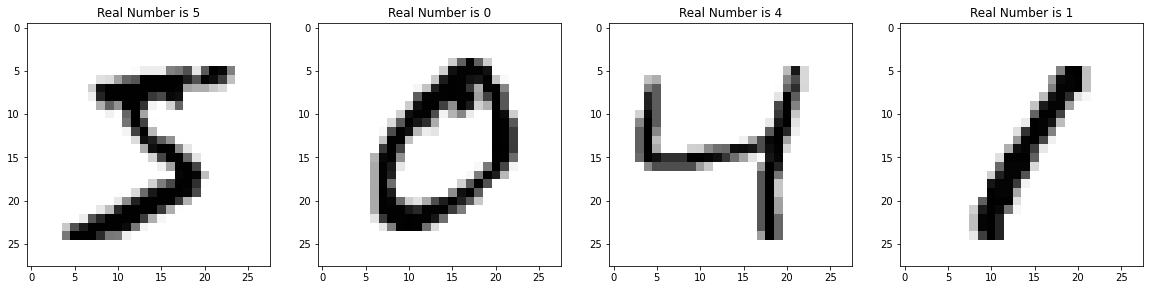

In [35]:
X_train__ = x_train.reshape(x_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(x_train[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

In [12]:
# Normalization
mean = np.mean(x_train)
std = np.std(x_train)

def standardize(x):
    return (x-mean)/std

In [13]:
net=Sequential()
 
net.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
net.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
net.add(BatchNormalization())    
net.add(MaxPooling2D(pool_size=(2,2)))

net.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
net.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
net.add(BatchNormalization())   
net.add(MaxPooling2D(pool_size=(2,2)))

net.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
net.add(BatchNormalization())    
net.add(MaxPooling2D(pool_size=(2,2)))
    
net.add(Flatten())

net.add(Dense(512,activation="relu"))
net.add(Dropout(rate=0.3))
net.add(Dense(units=256, activation='relu'))
net.add(Dropout(rate=0.3))
net.add(Dense(10,activation="softmax"))
    
net.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [14]:
net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

In [15]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=48,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


train_gen = datagen.flow(x_train_blurry, y_train, batch_size=128)
test_gen = datagen.flow(x_test_blurry, y_test, batch_size=128)

In [16]:
epochs = 100
batch_size = 128
train_steps = x_train_blurry.shape[0] // batch_size
valid_steps = x_test_blurry.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [17]:
history = net.fit(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

Epoch 1/100
468/468 [==============================] - 287s 597ms/step - loss: 0.4515 - accuracy: 0.8558 - val_loss: 0.3826 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 2/100
468/468 [==============================] - 297s 636ms/step - loss: 0.1476 - accuracy: 0.9563 - val_loss: 0.1444 - val_accuracy: 0.9541 - lr: 0.0010
Epoch 3/100
468/468 [==============================] - 363s 776ms/step - loss: 0.1170 - accuracy: 0.9665 - val_loss: 0.1016 - val_accuracy: 0.9689 - lr: 0.0010
Epoch 4/100
468/468 [==============================] - 308s 659ms/step - loss: 0.0965 - accuracy: 0.9730 - val_loss: 0.1045 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 5/100
468/468 [==============================] - 230s 492ms/step - loss: 0.0924 - accuracy: 0.9736 - val_loss: 0.0813 - val_accuracy: 0.9747 - lr: 0.0010
Epoch 6/100
468/468 [==============================] - 178s 380ms/step - loss: 0.0840 - accuracy: 0.9760 - val_loss: 0.0606 - val_accuracy: 0.9813 - lr: 0.0010
Epoch 7/100
468/468 [===================

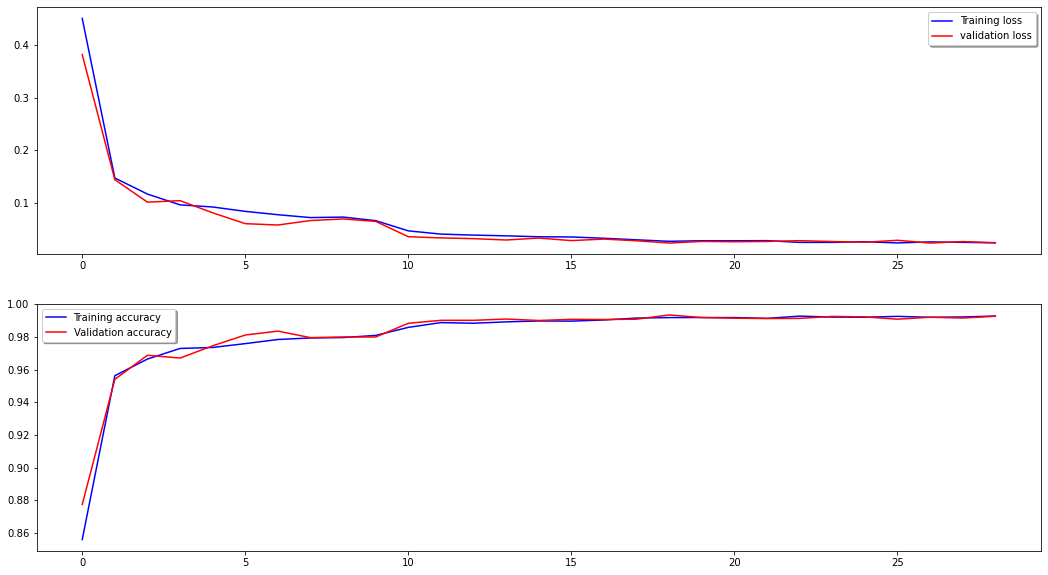

In [18]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

313/313 [==============================] - 10s 31ms/step


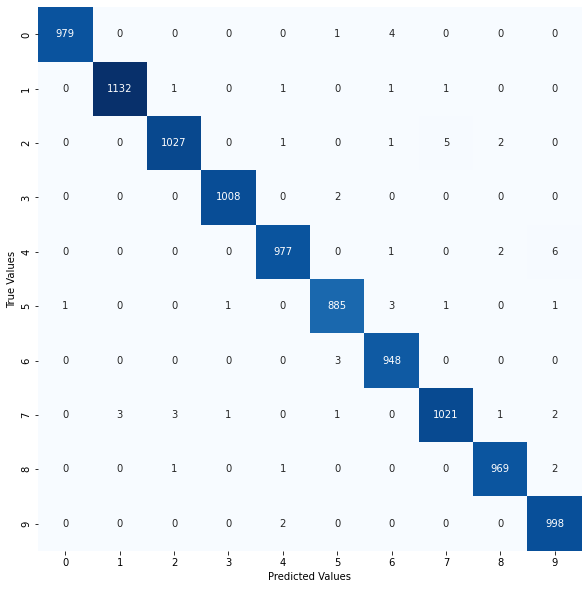

In [19]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = net.predict(x_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

313/313 [==============================] - 6s 19ms/step


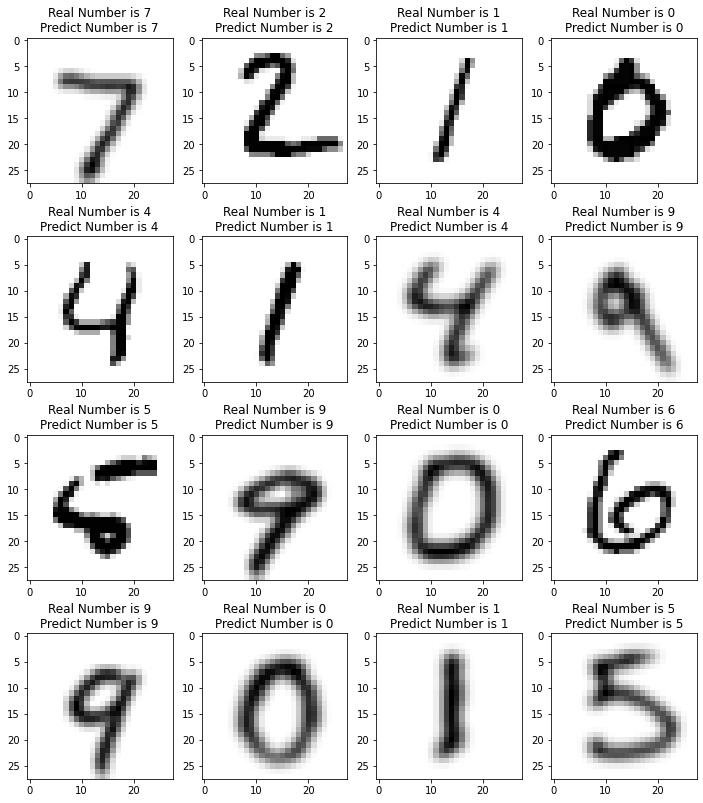

In [58]:
y_pred = net.predict(x_test)
X_test__ = x_test_blurry.reshape(x_test_blurry.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

In [52]:
datagen_test = ImageDataGenerator(
    rotation_range=45, 
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
)
datagen_test.fit(x_test_blurry)

# PERFORMANCE ON BLURRED + ROTATED TEST
results_both = net.evaluate(x_test.reshape(x_test.shape[0], 28, 28, 1), y_test)

313/313 [==============================] - 5s 17ms/step - loss: 0.0169 - accuracy: 0.9944


In [53]:
results_both_tw = net.evaluate(datagen_test.flow(x_test_blurry, y_test))

313/313 [==============================] - 6s 19ms/step - loss: 0.0298 - accuracy: 0.9906


In [54]:
results_both_tw = net.evaluate(x_test_blurry, y_test)

313/313 [==============================] - 6s 19ms/step - loss: 0.0168 - accuracy: 0.9946


In [55]:
results_both = net.evaluate(datagen_test.flow(x_test.reshape(x_test.shape[0], 28, 28, 1), y_test))

313/313 [==============================] - 6s 20ms/step - loss: 0.0241 - accuracy: 0.9926


In [56]:
net.save("mnist_net_19016338.h5")